In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import re

In [2]:
def str2time(s):
        ls = list(map(lambda x : float(x), s.split(':'))) # hh : mm : ss : ms : ???

        return round(ls[0] * 3600 + ls[1] * 60 + ls[2] + ls[3] / 1000., 2)

In [3]:
def get_evolution_from_log():
    evolution = [[[]] * M for i in range(0,N)]

    max_time = 0.
    max_val = 0.

    for ln in open(filename,"r").readlines():
        if ln.startswith("0 / L / Y /"):

            time = re.compile(r"\d+:\d+:\d+:\d+:\d+[\.\d+]*").search(ln.split('/')[3]).group(0)
            cell = re.compile(NOMBRE_MODELO_CELL_DEVS + "\(\d+,\d+,0\)").findall(ln)
            val  = re.compile(r"-*\d+[\.\d+]*").search(ln.split('/')[6]).group(0)

            if len(cell) == 0:
                continue
            cell = cell[0]
            coord = re.search(re.compile(r"\(.*,.*,0\)"), cell).group(0)[1:-1].split(',')
            i, j = int(coord[0]), int(coord[1])
            evolution[i][j].append({
                "time" : time,
                "time_converted" : str2time(time),
                "val" : float(val)
            })
            max_time = max(max_time, str2time(time))
            max_val = max(max_val, val)

    return evolution, max_time

In [4]:
def get_cut_values(ev, pts):
    res = []
    i, j = 0, 0
    while i < len(ev)-1:
        if (ev[i]['time_converted'] <= pts[j] and ev[i+1]['time_converted'] > pts[j]) \
            or ev[i]['time_converted'] > pts[j]:
            res.append({
                'time' : pts[j], 
                'interval' : (ev[i]['time_converted'], ev[i+1]['time_converted']),
                'value' : ev[i]['val']
            })
            j = j+1        
        else:
            i = i + 1
    while j < len(pts):
        res.append({
            'time' : pts[j],
            'interval' : (ev[i-1]['time_converted'], ev[i]['time_converted']),
            'value' : ev[i]['val']
        })
        j = j+1  
    return res

# Ejemplos

In [55]:
# PARAMS
NOMBRE_EXPERIMENTO = 'exp_pedro_1'
NOMBRE_CARPETA = '100_1_0.2_0.4_0.4'
NOMBRE_ARCHIVO = 'new_log_valfile_exp_00.log'
NOMBRE_MODELO_CELL_DEVS = 'opinion'

MODELO = 'opinion-goodwin-minsky'

filename = '../modelos/' + NOMBRE_MODELO_CELL_DEVS + '/' + MODELO + '/experimentos/' \
            + NOMBRE_EXPERIMENTO + '/' + NOMBRE_CARPETA \
            +'/result_logs/' + NOMBRE_ARCHIVO

# Parametros
N = 10
M = 10

# Cantidad de instantes en los que quiero conocer el valor exacto de cada celda
n_cuts = 100

In [56]:
evolution, max_time = get_evolution_from_log()
evolution_values = [[[]] * M for i in range(0,N)]

pts = np.linspace(0,max_time, n_cuts)

for i in range(0,N):
    for j in range(0,M):
        evolution_values[i][j] = get_cut_values(evolution[i][j], pts)

In [57]:
# Enter cell to plot evolution
y = list(map(lambda x : x['time'], evolution_values[0][0]))
xs = [list(map(lambda x : x['value'], evolution_values[i][j])) for i in range(0,2) for j in range(0,2)]
z = list(map(sum, zip(*xs)))      

In [66]:
evolution_values[9][8]

[{'interval': (0.0, 0.1), 'time': 0.0, 'value': 2.91975},
 {'interval': (0.5, 0.6), 'time': 0.55555555555555558, 'value': 2.81975},
 {'interval': (1.1, 1.2), 'time': 1.1111111111111112, 'value': 0.53822},
 {'interval': (1.6, 1.7), 'time': 1.6666666666666667, 'value': 2.31975},
 {'interval': (2.2, 2.3), 'time': 2.2222222222222223, 'value': 0.5},
 {'interval': (2.7, 2.8), 'time': 2.7777777777777777, 'value': 2.11975},
 {'interval': (3.3, 3.4), 'time': 3.3333333333333335, 'value': 0.05},
 {'interval': (3.8, 3.9), 'time': 3.8888888888888893, 'value': 1.81975},
 {'interval': (4.4, 4.5), 'time': 4.4444444444444446, 'value': 1.81975},
 {'interval': (5.0, 5.1), 'time': 5.0, 'value': 0.05},
 {'interval': (5.5, 5.6), 'time': 5.5555555555555554, 'value': 1.41975},
 {'interval': (6.1, 6.2), 'time': 6.1111111111111116, 'value': 1.21975},
 {'interval': (6.6, 6.7), 'time': 6.666666666666667, 'value': 2.23816},
 {'interval': (7.2, 7.3), 'time': 7.2222222222222223, 'value': 1.51975},
 {'interval': (7.7

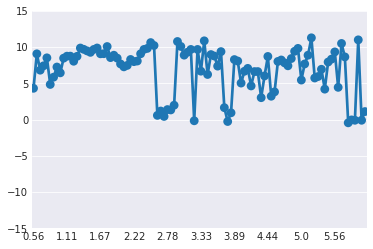

In [58]:
sns.set_style("darkgrid")
ax = sns.pointplot(x=list(map(lambda a : round(a,2), x)), y=z)
ax.set_ylim(-15,15)

import matplotlib.ticker as ticker
tick_spacing = 10
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))